# **ЭКОПСИ Консалтинг** 

## Описание данных:
Вам представлены данные о доходах сотрудников участка горячего проката за год, в том числе данные, описывающие специфику рабочих мест.
## Задание:
* Выявите тип и формулу зависимости оклада, премии и доплат от приведенных в таблице данных.
* Выявите все возможные зависимости между размерами оклада, премии и доплат.



# 1. Подготовка данных:

Подключим нужные библиотеки:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Выведем первичную информацию:

In [2]:
df = pd.read_excel('/content/drive/MyDrive/ЭКОПСИ Консалтинг/База данных.xlsx')
df.head()

,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход
0,2009-01-01,Нагревальщик металла,7,Нагревательные печи,22,580,26020.0
1,2009-01-01,Нагревальщик металла,6,Нагревательные печи,22,580,22980.0
2,2009-01-01,Нагревальщик металла,5,"Нагревательные печи, нагрев",22,580,20350.0
3,2009-01-01,Нагревальщик металла,5,"Нагревательные печи, кантовка",22,580,20350.0
4,2009-01-01,Нагревальщик металла,4,Нагревательные печи,22,580,18090.0


Для простоты заменим названия столбцов на английские аналоги:

In [3]:
df.columns = ['date', 'profession', 'rank', 'equipment', 'harmful', 'production', 'income']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        264 non-null    datetime64[ns]
 1   profession  264 non-null    object        
 2   rank        264 non-null    int64         
 3   equipment   264 non-null    object        
 4   harmful     264 non-null    int64         
 5   production  264 non-null    int64         
 6   income      264 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 14.6+ KB


## Вывод:
Данные состоят из 7 столбцов и 264 строк:
  * Дата - период времени. 
     * Задача: определить диаппазон значений.
  * Профессия - название профессии. 
     * Задача: определить список уникальных значений профессий и количество работников каждой профессии, также определить, меняется ли состав из месяца в месяц.
  * Разряд - разряд работника. 
     * Задача: определить, как влияет разряд на оклад, доплаты.
  * Оборудование - оборудование, на котором работает сотрудник.
     * Задача: определить, влияет ли оборудование, на котором работает сотрудник, на оклад, доплаты.
  * Вредность - уровень вредности работы в баллах.
     * Задача: определить стоимость одной единицы вредности.
  * Объем производства - количество произведенной продукции.
     * Задача: определить, является ли объем сдельным или является единым для всего предприятия. Определить точку, где начинается премия.
  * Доход - суммарный заработок работника за месяц.
     * Задача: определить, по какой формуле расчитывается зарплата. 

# 2. Анализ данных:

Определим диапазон значений месяца:

In [5]:
print(df.date.min())
print(df.date.max())

2009-01-01 00:00:00
2009-12-01 00:00:00


В данной таблице временной диапазон один год: с января по декабрь. Для простоты оставим только значения месяцев:

In [6]:
df['date'] = df['date'].dt.month

Далее сгруппируем объем производства по месяцам:

In [7]:
pd.DataFrame(df.groupby('date')['production'].mean())

,production
date,
1,580
2,790
3,820
4,1200
5,1250
6,950
7,1400
8,1180
9,1080


Объем производства один на все предприятие, а следовательно премия зависит от определенного объема. Если мы возьмем объем производства помесячно и среднюю зарплату сотрудников, мы увидим, в какой точке эта средняя зарплата начнет расти, там заканчивается оклад и начинается премия. Построим таблицу объема продукции и средней зарплаты по предприятию, отсортируем по возрастанию объем произведенной продукции. Дифференцируем эти два столбца и посчитаем стоимость одной дополнительной единицы продукции:


In [8]:
bonus = pd.DataFrame({
    'production': df['production'].unique(), 
    'income': df.pivot_table(index='date', values='income', aggfunc='mean')['income']
    }).sort_values('production')

bonus['diff_production'], bonus['diff_income'] = [bonus[i].diff() for i in ['production', 'income']]
bonus['result'] = bonus['diff_income'] / bonus['diff_production']  
bonus

,production,income,diff_production,diff_income,result
date,,,,,
1,580,19309.090909,NaN,NaN,NaN
10,780,19309.090909,200.0,0.000000,0.000000
2,790,19309.090909,10.0,0.000000,0.000000
12,810,19309.090909,20.0,0.000000,0.000000
3,820,19309.090909,10.0,0.000000,0.000000
6,950,20278.877005,130.0,969.786096,7.459893
11,1020,20957.727273,70.0,678.850267,9.697861
9,1080,21539.598930,60.0,581.871658,9.697861
8,1180,22509.385027,100.0,969.786096,9.697861


Средняя стоимость одной дополнительной единицы продукции равен 9.697861р, рост премии линейный. В точке с объемом 950 ед., стоимость составляет 7.459893р, так происходит потому, что цена начинает свой рост не с 820 ед., а с точки, которая нам пока неизвестна, но находящаяся в диапазоне от 820 ед. до 950 ед. То есть, рост происходит не на всем диапазоне, отсюда и значение низкое. Найдем точку начала премии.  Разделим дельту стоимости в диапазоне объема от 820 ед до 950 ед (969.786096р) на стоимость одной дополнительной единицы продукции равной 9.697861р: 

In [9]:
969.786096 / 9.697861

99.99999958753791

100 ед продукции, вычтем их из объема:

In [10]:
950 - 100

850

Получается, что цена начинает свой рост с 850 ед. Это и есть точка, с которой начинается премия. Построим график производственного объема предприятия и константы объема, с которого начинается премия:

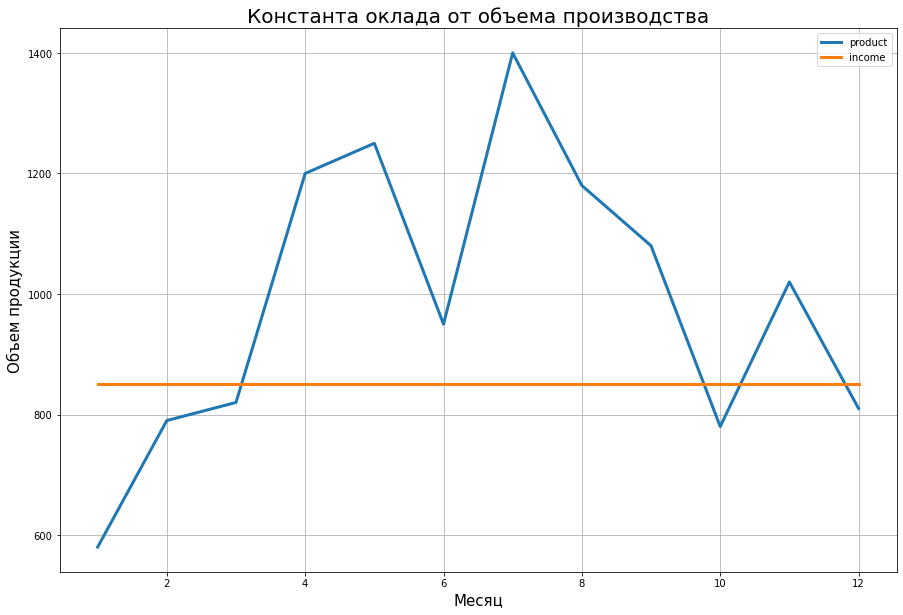

In [11]:
pd.DataFrame({
    'product': df.groupby('date')['production'].mean(),
    'income': np.linspace(850, 850, 12, dtype='int64')
}).plot(grid=True, figsize=(15, 10), linewidth=3)
plt.title("Константа оклада от объема производства", size=20)
plt.xlabel("Месяц", size=15)
plt.ylabel("Объем продукции", size=15)
plt.show()

Далее определим, меняется ли количество работников по месяцам:

In [12]:
[print('Месяц:', i, 'Количество работников:', df[df['date'] == i]['profession'].count()) for i in df['date'].unique()]

Месяц: 1 Количество работников: 22
Месяц: 2 Количество работников: 22
Месяц: 3 Количество работников: 22
Месяц: 4 Количество работников: 22
Месяц: 5 Количество работников: 22
Месяц: 6 Количество работников: 22
Месяц: 7 Количество работников: 22
Месяц: 8 Количество работников: 22
Месяц: 9 Количество работников: 22
Месяц: 10 Количество работников: 22
Месяц: 11 Количество работников: 22
Месяц: 12 Количество работников: 22


[None, None, None, None, None, None, None, None, None, None, None, None]

Количество сотрудников остается неизменным из месяца в месяц. Посмотрим структуру штата в месяце:

In [13]:
pd.DataFrame(df.groupby('profession')['date'].count() / 12).sort_values('date', ascending=False)

,date
profession,
Вальцовщик,5.0
Нагревальщик металла,5.0
Оператор поста управления,3.0
Подручный вальцовщика,3.0
Уборщик,2.0
Контролер качества готовой продукции,1.0
Огнеупорщик,1.0
Посадчик металла,1.0
Резчик горячего металла,1.0


Всего 22 сотрудника, которые не меняются из месяца в месяц. Посмотрим более детально на структуру штата:

In [14]:
df.query('date == 1')[['profession', 'rank', 'equipment', 'harmful', 'income']].sort_values('profession').reset_index(drop=True)

,profession,rank,equipment,harmful,income
0,Вальцовщик,7,Пилигримовые станы,18,25300.0
1,Вальцовщик,5,Калибровочный стан,18,19630.0
2,Вальцовщик,6,Пилигримовые станы,18,22260.0
3,Вальцовщик,6,Прошивной стан,18,22260.0
4,Вальцовщик,7,Прошивной стан,18,25300.0
5,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,22060.0
6,Нагревальщик металла,4,Нагревательные печи,22,18090.0
7,Нагревальщик металла,5,"Нагревательные печи, кантовка",22,20350.0
8,Нагревальщик металла,5,"Нагревательные печи, нагрев",22,20350.0
9,Нагревальщик металла,6,Нагревательные печи,22,22980.0


Как видно из вывода, оборудование, на котором работает сотрудник, не влияет на уровень зарплаты. Влияние имеют: профессия, разряд, вредность и объем производства. Определим стоимость одной единицы вредности. Есть две должности уборщика: одна с вредностью, другая без нее. Для простоты, уборщика вспомогательных помещений назовем "Уборщик вспомогательных помещений": 

In [15]:
df.loc[(df['profession'] == 'Уборщик') & (df['harmful'] == 0), 'profession'] = 'Уборщик вспомогательных помещений'

Далее найдем разницу между зарплатой уборщика и уборщика вспомогательных помещений и разделим на коэффициент вредности данной профессии: 

In [16]:
(df.query(
    'date == 1 and profession == "Уборщик"'
)['income'].values - df.query(
    'date == 1 and profession == "Уборщик вспомогательных помещений"'
)['income'].values) / 18

array([180.])

Одна единица вредности равна 180р. Далее, умножим стоимость вредности на коэффициент и вычтем из зарплаты стоимость вредности. Также создадим столбец со стоимостью месячной вредности: 

In [17]:
df['income'] = df['income'] - df['harmful'] * 180 
df['harmful_month'] = df['harmful'] * 180

Далее, для оклада (без вредности) посчитаем стоимость одной дополнительной единицы продукции для каждой профессии с учетом разряда и сохраним в отдельном столбце: 

In [18]:
def bonus(profession, rank):
  info = df.query('profession == @profession and rank == @rank').sort_values('production')
  info['diff_production'], info['diff_income'] = [info[i].diff() for i in ['production', 'income']]
  info['result'] = info['diff_income'] / info['diff_production']
  return info[info['date'] == 7]['result'].values

df['bonus'] = np.nan

prof_list = df[df['date'] == 1][['profession', 'rank']]

for profession, rank in prof_list.values:
  df.loc[(df['profession'] == profession) & (df['rank'] == rank), 'bonus'] = df['bonus'].fillna(bonus(profession, rank).tolist()[0])

# 3. Общий вывод:

Выведем в таблице информацию об уникальных должностях с колонками 'Профессия', 'Разряд', 'Вредность(балл.)', 'Вредность(сумма/месяц)', 'Оклад', 'Премия(доп. единица)'. Переименуем столбцы:

In [19]:
final = df.iloc[prof_list[~prof_list.duplicated()].index][[
  'profession', 'rank', 'harmful', 'harmful_month', 'income', 'bonus'
]].sort_values('profession').reset_index(drop=True)

final.columns = ['Профессия', 'Разряд', 'Вредность(балл.)', 'Вредность(сумма/месяц)', 'Оклад', 'Премия(доп.еденица)'] 
final

,Профессия,Разряд,Вредность(балл.),Вредность(сумма/месяц),Оклад,Премия(доп.еденица)
0,Вальцовщик,5,18,3240,16390.0,9.641176
1,Вальцовщик,6,18,3240,19020.0,11.188235
2,Вальцовщик,7,18,3240,22060.0,12.976471
3,Контролер качества готовой продукции,7,0,0,22060.0,12.976471
4,Нагревальщик металла,7,22,3960,22060.0,12.976471
5,Нагревальщик металла,4,22,3960,14130.0,8.311765
6,Нагревальщик металла,5,22,3960,16390.0,9.641176
7,Нагревальщик металла,6,22,3960,19020.0,11.188235
8,Огнеупорщик,4,11,1980,14130.0,8.311765
9,Оператор поста управления,5,8,1440,16390.0,9.641176


Зарплата работников складывается из оклада в зависимости от профессии и разряда, плюс доплата за вредность 180р за единицу вредности. Также, если объем производства в месяц превышает 850ед. за каждую дополнительную единицу начисляется доплата в зависимости от професии и разряда. В таблице выше представлены уникальные профессии с разрядом, коэффициентом вредности, суммой доплат за вредность в месяц, окладом, а также индивидуальной премией за дополнительную единицу продукции. 